In [1]:
! cp /kaggle/input/voc-pascal-2012-segmentation/best.pth .

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
cp: cannot stat '/kaggle/input/voc-pascal-2012-segmentation/best.pth': No such file or directory


In [2]:
""" Parts of the U-Net model """
import os
import random
import numpy as np
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.cuda.amp as amp
import matplotlib
import matplotlib.pyplot as plt


import albumentations as A

import torch.cuda.amp as amp

import warnings
warnings.filterwarnings("ignore")

/home/linsam1234/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

class DeepSupervisionLoss(nn.Module):
    def __init__(self, num_classes):
        super(DeepSupervisionLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss() if num_classes > 1 else nn.BCEWithLogitsLoss()

    def forward(self, outputs, target):
        # 解包输出
        final, dsv1, dsv2, dsv3, dsv4 = outputs

        # 主损失
        loss_final = self.criterion(final, target)

        # 辅助损失
        loss_dsv1 = self.criterion(dsv1, target)
        loss_dsv2 = self.criterion(dsv2, target)
        loss_dsv3 = self.criterion(dsv3, target)
        loss_dsv4 = self.criterion(dsv4, target)

        # 总损失 (权重可调整)
        return loss_final + 0.4 * loss_dsv1 + 0.3 * loss_dsv2 + 0.2 * loss_dsv3 + 0.1 * loss_dsv4
# 通道注意力机制
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# 空间注意力机制
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_out = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv(x_out)
        return self.sigmoid(x_out)

# ASPP模块
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        # 不同扩张率的卷积
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels//4, kernel_size=3, padding=3, dilation=3)
        self.conv3 = nn.Conv2d(in_channels, out_channels//4, kernel_size=3, padding=6, dilation=6)
        self.conv4 = nn.Conv2d(in_channels, out_channels//4, kernel_size=3, padding=12, dilation=12)



        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels//4)
        self.bn4 = nn.BatchNorm2d(out_channels//4)


        self.conv_out = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.relu(self.bn1(self.conv1(x)))
        x2 = self.relu(self.bn2(self.conv2(x)))
        x3 = self.relu(self.bn3(self.conv3(x)))
        x4 = self.relu(self.bn4(self.conv4(x)))


        x_out = torch.cat([x1, x2, x3, x4], dim=1)
        x_out = self.relu(self.bn_out(self.conv_out(x_out)))
        return x_out

# 改进的解码器模块
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # 添加注意力机制
        self.ca = ChannelAttention(skip_channels)
        self.sa = SpatialAttention()

    def forward(self, x, skip):
        x = self.up(x)

        # 对齐尺寸
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        # 应用注意力机制增强特征
        skip = skip * self.ca(skip)
        skip = skip * self.sa(skip)

        # 拼接并卷积
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class ResUNet(nn.Module):
    def __init__(self, in_channels, num_classes, pretrained=True):
        super(ResUNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes


        # 使用ResNet34作为编码器
        resnet = models.resnet34(pretrained=pretrained)

        # 编码器部分
        self.firstconv = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool

        self.encoder1 = resnet.layer1  # 64通道
        self.encoder2 = resnet.layer2  # 128通道
        self.encoder3 = resnet.layer3  # 256通道
        self.encoder4 = resnet.layer4  # 512通道


        # 中间连接部分
        self.center = ASPP(512, 512)

        # 解码器部分
        self.decoder4 = DecoderBlock(512, 256, 256)
        self.decoder3 = DecoderBlock(256, 128, 128)
        self.decoder2 = DecoderBlock(128, 64, 64)
        self.decoder1 = DecoderBlock(64, 64, 32)

        # 深监督输出
        self.dsv4 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.dsv3 = nn.Conv2d(128, num_classes, kernel_size=1)
        self.dsv2 = nn.Conv2d(64, num_classes, kernel_size=1)
        self.dsv1 = nn.Conv2d(32, num_classes, kernel_size=1)

        # 最终输出
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)

        # 前向传播方法
    def forward(self, x):
        # 保存原始大小
        input_size = x.size()[2:]

        # 编码器路径
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x_skip1 = x  # 64通道, 1/2大小
        x = self.firstmaxpool(x)

        x = self.encoder1(x)
        x_skip2 = x  # 64通道, 1/4大小

        x = self.encoder2(x)
        x_skip3 = x  # 128通道, 1/8大小

        x = self.encoder3(x)
        x_skip4 = x  # 256通道, 1/16大小

        x = self.encoder4(x)  # 512通道, 1/32大小

        # 中间连接
        x = self.center(x)

        # 解码器路径
        x = self.decoder4(x, x_skip4)
        d4 = x  # 用于深监督

        x = self.decoder3(x, x_skip3)
        d3 = x  # 用于深监督

        x = self.decoder2(x, x_skip2)
        d2 = x  # 用于深监督

        x = self.decoder1(x, x_skip1)
        d1 = x  # 用于深监督

        # 最终输出
        final = self.final(x)
        final = F.interpolate(final, size=input_size, mode='bilinear', align_corners=True)

        if self.training:
            # 深监督输出
            dsv4 = self.dsv4(d4)
            dsv4 = F.interpolate(dsv4, size=input_size, mode='bilinear', align_corners=True)

            dsv3 = self.dsv3(d3)
            dsv3 = F.interpolate(dsv3, size=input_size, mode='bilinear', align_corners=True)

            dsv2 = self.dsv2(d2)
            dsv2 = F.interpolate(dsv2, size=input_size, mode='bilinear', align_corners=True)

            dsv1 = self.dsv1(d1)
            dsv1 = F.interpolate(dsv1, size=input_size, mode='bilinear', align_corners=True)

            return final, dsv1, dsv2, dsv3, dsv4
        else:
            return final


In [4]:
#read dataset
"""picture agument class"""
class ToTensor(object):
    def __init__(self):
        pass
    def __call__(self,img, mask):
        img = torch.from_numpy(img.copy()).contiguous()/255.0
        img = img.permute(2,0,1)
        mask = torch.from_numpy(mask.copy()).contiguous()
        return img, mask

"""voc mask rgbcolor"""
VOC_COLORMAP = np.array([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]])

"""voc class names"""
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']


class ListDataset(Dataset):
    def __init__(self, list_path: str, img_size: int = 416, transformList: list = []):
        abs_path = os.path.abspath(list_path)
        prpath = os.path.dirname(abs_path)
        with open(list_path, "r") as file:
            files = file.readlines()
            self.img_files = []
            self.mask_files = []
            for path in files:
                image_file = os.path.join(prpath, "JPEGImages", path.strip() + ".jpg")
                label_file = os.path.join(prpath, "mask", path.strip() + ".png")
                self.img_files.append(image_file)
                self.mask_files.append(label_file)
        self.img_size = img_size
        self.transformList = transformList

    def __getitem__(self, index):
        #  Image
        try:
            img_path = self.img_files[index % len(self.img_files)].rstrip()
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(e)
        #  mask
        try:
            mask_path = self.mask_files[index % len(self.img_files)].rstrip()
            mask = Image.open(mask_path).convert('RGB')
        except Exception as e:
            print(e)
            return
        # transform
        assert img.size == mask.size , "iamge and mask have different size"
        w, h = img.size
        imgsize = max(w, h)
        dw = (imgsize - w) // 2
        dh = (imgsize - h) // 2
        img_pad = Image.new("RGB", (imgsize, imgsize), (0, 0, 0))
        img_pad.paste(img, (dw, dh))
        mask_pad = Image.new("RGB", (imgsize, imgsize), (0, 0, 0))
        mask_pad.paste(mask, (dw, dh))
        img_pad = img_pad.resize((self.img_size, self.img_size), resample=Image.BICUBIC)
        mask_pad = mask_pad.resize((self.img_size, self.img_size), resample=Image.NEAREST)
        img_pad = np.array(img_pad, dtype=np.uint8)
        mask_pad = np.array(mask_pad, dtype=np.uint8)
        mask_label = np.zeros((mask_pad.shape[0], mask_pad.shape[1]), dtype=np.int64)
        for index, color in enumerate(VOC_COLORMAP):
            classmask = np.all(mask_pad == color, axis=-1)
            mask_label[classmask] = index

        try:
            for transform in self.transformList:
                img, mask_label = transform(img_pad, mask_label)
        except Exception as e:
            print("Could not apply transform.")
            print(e)
            #traceback.print_exc()
            return

        return img, mask_label

    def __len__(self):
        return len(self.img_files)

def workerSeedSet(worker_id):
    # NumPy
    uint64_seed = torch.initial_seed()
    ss = np.random.SeedSequence([uint64_seed])
    np.random.seed(ss.generate_state(4))
    # random
    worker_seed = torch.initial_seed() % 2 ** 32
    random.seed(worker_seed)

class AlbuTransform(object):
    def __init__(self):
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.05),  # 水平翻转
            A.RandomBrightnessContrast(p=0.05), #随机亮度调整
            A.GaussianBlur(blur_limit=2, p=0.05) #高斯模糊
        ])

    def __call__(self, img, mask):
        augmented = self.transform(image=img, mask=mask)
        return augmented['image'], augmented['mask']

"""create dataset and dataloader"""
def createDataLoader(list_path: str, batch_size: int, img_size: int = 256, shuffle = True, n_cpu: int = 4, transform=[AlbuTransform(),ToTensor()]):

    dataset = ListDataset(list_path, img_size, transform)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=n_cpu,
        pin_memory=True,
        worker_init_fn=workerSeedSet)

    return dataloader


In [5]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = torch.flatten(y_true)
    y_pred_flatten = torch.flatten(y_pred)

    intersection = torch.sum(y_true_flatten * y_pred_flatten)
    union = torch.sum(y_true_flatten) + torch.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)
    
#evaluate function
def eval_net(net, loader, device):
    net.eval()
    n_val = len(loader)
    tot = 0
    tot_img = 0
    for imgs, true_masks in tqdm(loader, desc="验证中"):
        imgs = imgs.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device, dtype=torch.float32 if net.num_classes == 1 else torch.long)
        tot_img += len(imgs)
        with torch.no_grad():
            mask_pred = net(imgs)  # 在评估模式下只返回最终输出

        for b in range(imgs.shape[0]):
            if net.num_classes==1:
                pred = torch.sigmoid(mask_pred[b])
                pred = (pred > 0.5).float()
                tot += dice_coef(pred, true_masks[b]).item()
            else:
                gt = F.one_hot(true_masks[b], num_classes=net.num_classes)
                pred = F.one_hot(torch.argmax(mask_pred[b],dim=0), num_classes=net.num_classes)
                tot += dice_coef(pred, gt).item()

    return tot / tot_img

In [6]:
# train function
from torch import optim
from tqdm import tqdm

loss_graph=[]
dice_graph=[]

def train_improved_net(net, device, epochs, lr, train_loader, val_loader):
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-08)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    criterion = DeepSupervisionLoss(net.num_classes)
    scaler = amp.GradScaler()

    best_score = 0

    for epoch in range(epochs):
        net.train()
        epoch_loss = 0
        for imgs, true_masks in tqdm(train_loader, desc=f"训练第{epoch + 1}轮"):
            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=torch.long)

            with amp.autocast():
                outputs = net(imgs)
                loss = criterion(outputs, true_masks)

            epoch_loss += loss.item()

            optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()  # 使用scaler缩放loss
            scaler.step(optimizer)
            scaler.update()

        scheduler.step(epoch_loss)

        # 在验证集上评估
        net.eval()
        val_score = eval_net(net, val_loader, device)

        print(f"第{epoch + 1}轮 训练损失:{epoch_loss}")
        print(f"第{epoch + 1}轮 验证dice分数:{val_score}")

        loss_graph.append(epoch_loss)
        dice_graph.append(val_score)

        if val_score > best_score:
            best_score = val_score
            torch.save(net.state_dict(), f'best.pth')




In [7]:
# train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
net = ResUNet(in_channels=3, num_classes=21, pretrained=True)
net.to(device=device)

train_loader = createDataLoader(list_path = 'kaggle/input/voc-pascal-2012-segmentation/train.txt',
                                batch_size = 16,
                                shuffle = True,
                                img_size = 256, 
                                n_cpu = 2,
                                transform=[AlbuTransform(),ToTensor()])   #AlbuTransform()
val_loader = createDataLoader(list_path = 'kaggle/input/voc-pascal-2012-segmentation/valid.txt',
                                batch_size = 16, 
                                img_size = 256,
                                shuffle = False,
                                n_cpu = 2,
                                transform=[ToTensor()])

train_improved_net(
    net=net,
    device=device,
    epochs=100,
    lr=1.0e-4,
    train_loader=train_loader,
    val_loader=val_loader
)


cuda


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]


第1轮 训练损失:690.2756609916687
第1轮 验证dice分数:0.7753924649227953


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


第2轮 训练损失:545.8962647914886
第2轮 验证dice分数:0.8073849481231762


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.93it/s]


第3轮 训练损失:459.5656771659851
第3轮 验证dice分数:0.8059839619064821


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.77it/s]


第4轮 训练损失:381.39895701408386
第4轮 验证dice分数:0.8235079136966228


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


第5轮 训练损失:313.6408842802048
第5轮 验证dice分数:0.8332102830373198


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.76it/s]


第6轮 训练损失:259.74867832660675
第6轮 验证dice分数:0.8276864710946026


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.89it/s]


第7轮 训练损失:215.65455627441406
第7轮 验证dice分数:0.8333289402938012


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


第8轮 训练损失:184.58685439825058
第8轮 验证dice分数:0.8522301828983921


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


第9轮 训练损失:159.98361110687256
第9轮 验证dice分数:0.8511114906436583


验证中: 100%|██████████| 37/37 [00:10<00:00,  3.56it/s]


第10轮 训练损失:143.5694717168808
第10轮 验证dice分数:0.8625877354402689


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


第11轮 训练损失:130.26516216993332
第11轮 验证dice分数:0.8658146405813011


验证中: 100%|██████████| 37/37 [00:10<00:00,  3.58it/s]


第12轮 训练损失:117.83744043111801
第12轮 验证dice分数:0.8638672146236916


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


第13轮 训练损失:107.14909726381302
第13轮 验证dice分数:0.8657280743940003


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]


第14轮 训练损失:100.74947914481163
第14轮 验证dice分数:0.8610513819122805


验证中: 100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


第15轮 训练损失:93.2971605360508
第15轮 验证dice分数:0.8673856468491039


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.89it/s]


第16轮 训练损失:86.4313570857048
第16轮 验证dice分数:0.8613368145495295


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


第17轮 训练损失:83.3517673611641
第17轮 验证dice分数:0.8707061794364432


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


第18轮 训练损失:74.67233645915985
第18轮 验证dice分数:0.8709699061681639


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


第19轮 训练损失:73.53339272737503
第19轮 验证dice分数:0.867694983607091


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


第20轮 训练损失:70.6928758919239
第20轮 验证dice分数:0.8740921476999646


验证中: 100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


第21轮 训练损失:63.90239500999451
第21轮 验证dice分数:0.8711239986415589


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


第22轮 训练损失:62.40005896985531
第22轮 验证dice分数:0.877719296701572


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


第23轮 训练损失:59.94873608648777
第23轮 验证dice分数:0.8764614464897235


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


第24轮 训练损失:55.909533336758614
第24轮 验证dice分数:0.875233147913146


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


第25轮 训练损失:52.52363905310631
第25轮 验证dice分数:0.8737212204299292


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.89it/s]


第26轮 训练损失:51.72694031894207
第26轮 验证dice分数:0.8792684129335459


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


第27轮 训练损失:46.44430862367153
第27轮 验证dice分数:0.8773138206164588


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.89it/s]


第28轮 训练损失:47.89616094529629
第28轮 验证dice分数:0.8745052584448564


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.76it/s]


第29轮 训练损失:48.18264313042164
第29轮 验证dice分数:0.8685720229128417


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


第30轮 训练损失:47.23336938023567
第30轮 验证dice分数:0.8745548704680611


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


第31轮 训练损失:40.42465380579233
第31轮 验证dice分数:0.8768535561054485


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


第32轮 训练损失:38.33628265559673
第32轮 验证dice分数:0.873799416560865


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


第33轮 训练损失:39.71531169116497
第33轮 验证dice分数:0.8715208169219834


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.89it/s]


第34轮 训练损失:43.119862638413906
第34轮 验证dice分数:0.8682731208016083


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


第35轮 训练损失:43.2913376763463
第35轮 验证dice分数:0.8745515222308157


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.80it/s]


第36轮 训练损失:38.77295961976051
第36轮 验证dice分数:0.8776225812132527


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


第37轮 训练损失:37.04180244356394
第37轮 验证dice分数:0.8809373885342023


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.90it/s]


第38轮 训练损失:36.14150298386812
第38轮 验证dice分数:0.8738448961828013


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


第39轮 训练损失:37.166422978043556
第39轮 验证dice分数:0.8714169382946774


验证中: 100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


第40轮 训练损失:34.67642717063427
第40轮 验证dice分数:0.8780598596990824


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


第41轮 训练损失:38.4168618619442
第41轮 验证dice分数:0.8761770844357296


验证中: 100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


第42轮 训练损失:34.589907608926296
第42轮 验证dice分数:0.8753529003410765


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.85it/s]


第43轮 训练损失:36.5774011015892
第43轮 验证dice分数:0.8811408308930503


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


第44轮 训练损失:34.50926884263754
第44轮 验证dice分数:0.8763882698775565


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.89it/s]


第45轮 训练损失:35.16586168855429
第45轮 验证dice分数:0.8786618223934599


验证中: 100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


第46轮 训练损失:32.56901001930237
第46轮 验证dice分数:0.8832140778595546


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


第47轮 训练损失:33.08671419322491
第47轮 验证dice分数:0.8792382586063693


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


第48轮 训练损失:34.90299737453461
第48轮 验证dice分数:0.871791447977668


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


第49轮 训练损失:33.249290861189365
第49轮 验证dice分数:0.8860806482836068


验证中: 100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


第50轮 训练损失:30.636296197772026
第50轮 验证dice分数:0.8799480229973997


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.92it/s]


第51轮 训练损失:30.43419562280178
第51轮 验证dice分数:0.8841729223421466


验证中: 100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


第52轮 训练损失:31.259053952991962
第52轮 验证dice分数:0.8830251231099484


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


第53轮 训练损失:30.087272569537163
第53轮 验证dice分数:0.8771407146192128


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


第54轮 训练损失:32.41782169789076
第54轮 验证dice分数:0.8789248412305658


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


第55轮 训练损失:29.973939791321754
第55轮 验证dice分数:0.87921953339315


验证中: 100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


第56轮 训练损失:28.711823262274265
第56轮 验证dice分数:0.8811476844559403


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


第57轮 训练损失:30.312344819307327
第57轮 验证dice分数:0.8738564317263215


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


第58轮 训练损失:29.251179575920105
第58轮 验证dice分数:0.8802009223869285


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.93it/s]


第59轮 训练损失:28.764451563358307
第59轮 验证dice分数:0.8755506170245836


验证中: 100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


第60轮 训练损失:30.900681041181087
第60轮 验证dice分数:0.8839696610464649


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


第61轮 训练损失:26.793223313987255
第61轮 验证dice分数:0.883733161880058


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


第62轮 训练损失:28.797129653394222
第62轮 验证dice分数:0.8866952952144486


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


第63轮 训练损失:28.20354411751032
第63轮 验证dice分数:0.883129735906987


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]


第64轮 训练损失:32.68263392150402
第64轮 验证dice分数:0.8805400459782746


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.85it/s]


第65轮 训练损失:28.630642667412758
第65轮 验证dice分数:0.8820663578105423


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.77it/s]


第66轮 训练损失:27.11200624704361
第66轮 验证dice分数:0.8859328861199767


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.97it/s]


第67轮 训练损失:25.366715967655182
第67轮 验证dice分数:0.8851270353098881


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.95it/s]


第68轮 训练损失:27.591441206634045
第68轮 验证dice分数:0.8808702528476715


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.92it/s]


第69轮 训练损失:27.844898477196693
第69轮 验证dice分数:0.8848790785051742


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.98it/s]


第70轮 训练损失:28.34246551245451
第70轮 验证dice分数:0.8840690687631048


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.95it/s]


第71轮 训练损失:27.456696435809135
第71轮 验证dice分数:0.8731783380537049


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


第72轮 训练损失:28.101719960570335
第72轮 验证dice分数:0.8835014459608349


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.90it/s]


第73轮 训练损失:26.16460630297661
第73轮 验证dice分数:0.8825481199175375


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


第74轮 训练损失:25.44178580492735
第74轮 验证dice分数:0.8854417317829656


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.97it/s]


第75轮 训练损失:23.948502883315086
第75轮 验证dice分数:0.8850127197354777


验证中: 100%|██████████| 37/37 [00:13<00:00,  2.76it/s]


第76轮 训练损失:24.7040493786335
第76轮 验证dice分数:0.8865048484573234


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.97it/s]


第77轮 训练损失:24.248667620122433
第77轮 验证dice分数:0.8870865684226283


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


第78轮 训练损失:23.026948735117912
第78轮 验证dice分数:0.8879326687259903


验证中: 100%|██████████| 37/37 [00:09<00:00,  4.01it/s]


第79轮 训练损失:22.609926123172045
第79轮 验证dice分数:0.8884682538783366


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


第80轮 训练损失:22.409323789179325
第80轮 验证dice分数:0.8888479151202311


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.95it/s]


第81轮 训练损失:21.516657829284668
第81轮 验证dice分数:0.889456259089923


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


第82轮 训练损失:21.146665949374437
第82轮 验证dice分数:0.8896796575541357


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.93it/s]


第83轮 训练损失:21.810729578137398
第83轮 验证dice分数:0.8894553968162111


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


第84轮 训练损失:21.822226360440254
第84轮 验证dice分数:0.8899499214227162


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.92it/s]


第85轮 训练损失:21.626018155366182
第85轮 验证dice分数:0.8904081744558815


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


第86轮 训练损失:22.075851935893297
第86轮 验证dice分数:0.8894228346351898


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.94it/s]


第87轮 训练损失:21.575512401759624
第87轮 验证dice分数:0.8902334182892205


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


第88轮 训练损失:21.878945045173168
第88轮 验证dice分数:0.8899005972500731


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.90it/s]


第89轮 训练损失:21.43920524418354
第89轮 验证dice分数:0.8904567130842912


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


第90轮 训练损失:20.83786218613386
第90轮 验证dice分数:0.8908742447455588


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.96it/s]


第91轮 训练损失:20.81678130477667
第91轮 验证dice分数:0.8904923860552381


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


第92轮 训练损失:23.063350684940815
第92轮 验证dice分数:0.8911459217963047


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.96it/s]


第93轮 训练损失:21.409811787307262
第93轮 验证dice分数:0.8899278496080565


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


第94轮 训练损失:21.274069726467133
第94轮 验证dice分数:0.8901184247247556


验证中: 100%|██████████| 37/37 [00:09<00:00,  4.00it/s]


第95轮 训练损失:21.49807658791542
第95轮 验证dice分数:0.8901658138934376


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


第96轮 训练损失:21.560677722096443
第96轮 验证dice分数:0.8904883056418973


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.92it/s]


第97轮 训练损失:20.773397535085678
第97轮 验证dice分数:0.8899064025686699


验证中: 100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


第98轮 训练损失:21.75187887996435
第98轮 验证dice分数:0.8908967107381052


验证中: 100%|██████████| 37/37 [00:09<00:00,  3.92it/s]


第99轮 训练损失:21.518384464085102
第99轮 验证dice分数:0.8905911657249947


验证中: 100%|██████████| 37/37 [00:09<00:00,  4.01it/s]

第100轮 训练损失:20.099143963307142
第100轮 验证dice分数:0.8897408288911521


<Figure size 1000x600 with 0 Axes>

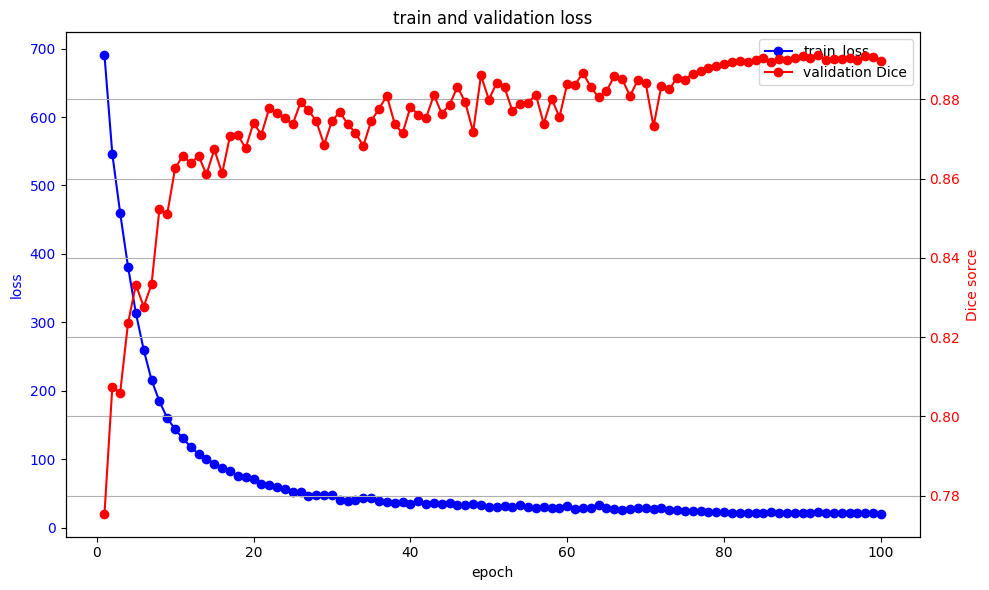

In [8]:
#绘制loss和sorce曲线图
plt.figure(figsize=(10, 6))

# 创建两个y轴
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# 绘制损失曲线
ax1.plot(range(1, len(loss_graph) + 1), loss_graph, 'b-', marker='o', label='train_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 绘制Dice分数曲线
ax2.plot(range(1, len(dice_graph) + 1), dice_graph, 'r-', marker='o', label='validation Dice')
ax2.set_ylabel('Dice sorce', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('train and validation loss')
plt.grid(True)
plt.tight_layout()
plt.show()

验证中: 100%|██████████| 37/37 [00:09<00:00,  4.03it/s]


the valid dice score is 0.891.
show some sammple


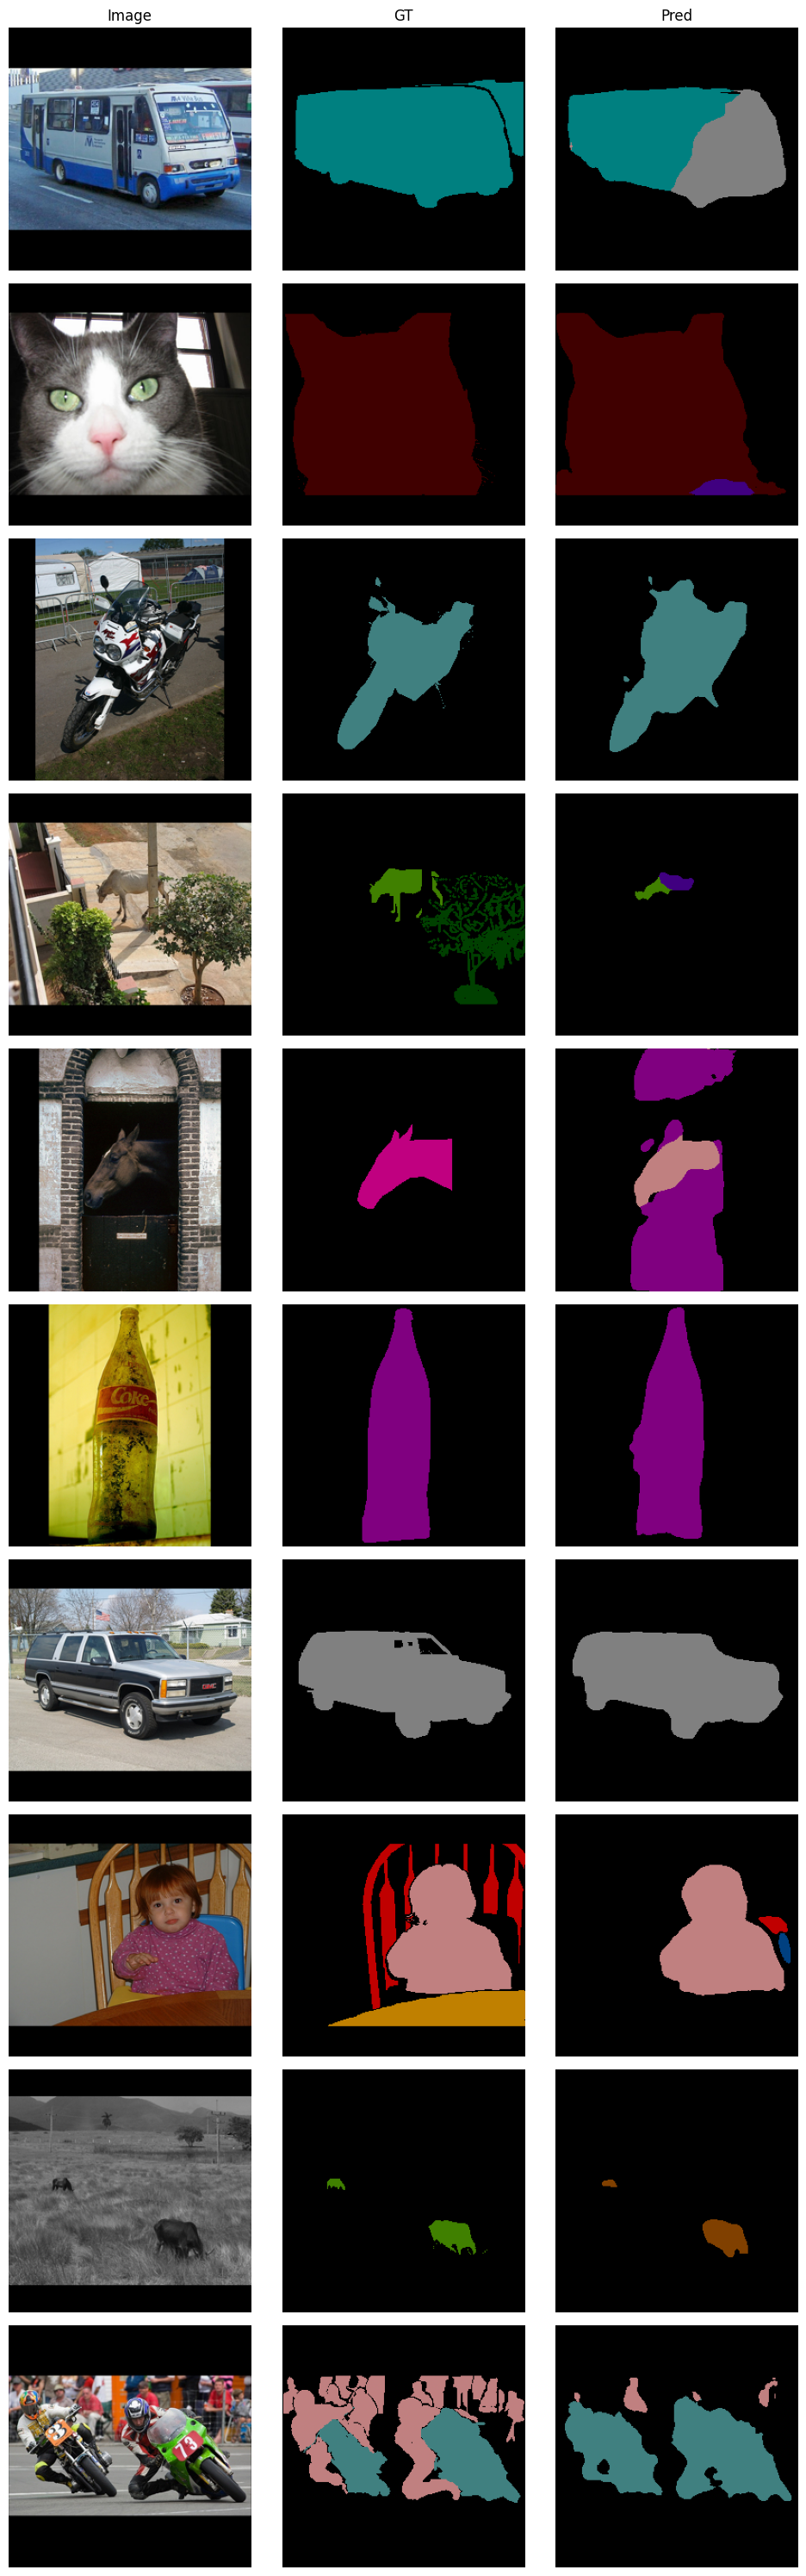

In [9]:
#test
import math

net.load_state_dict(torch.load(f'best.pth'))
net.eval()

dice_score = eval_net(net, val_loader, device)
print("the valid dice score is {:.3f}.".format(dice_score))

#show some sammple
print("show some sammple")
train_dataset = ListDataset(list_path = 'kaggle/input/voc-pascal-2012-segmentation/train.txt', img_size = 256 , transformList = [ToTensor()])
valid_dataset = ListDataset(list_path = 'kaggle/input/voc-pascal-2012-segmentation/valid.txt', img_size = 256 , transformList = [ToTensor()])

images, masks = zip(*[valid_dataset[i] for i in range(1500,2500,100)])
images = torch.stack(images)


with torch.no_grad():
    pre = net(images.to(device)).argmax(dim=1).cpu()

num_samples = len(images)
cols = 3  # 每行显示3列（原图、GT、预测）
rows = math.ceil(num_samples)  # 每个样本占一行

plt.figure(figsize=(10, 3 * num_samples))  # 高度随样本数变化

for i, img in enumerate(images):
    img = img.permute(1,2,0).numpy() * 255
    img = img.astype(np.uint8)
    gt_masks = np.zeros_like(img)
    pr_masks = np.zeros_like(img)
    for cls in range(21):
        gt_masks[masks[i] == cls] = VOC_COLORMAP[cls]
        pr_masks[pre[i] == cls] = VOC_COLORMAP[cls]

    plt.subplot(num_samples, cols, i * 3 + 1)
    plt.imshow(img)
    plt.axis('off')
    if i == 0:
        plt.title('Image')

    plt.subplot(num_samples, cols, i * 3 + 2)
    plt.imshow(gt_masks)
    plt.axis('off')
    if i == 0:
        plt.title('GT')

    plt.subplot(num_samples, cols, i * 3 + 3)
    plt.imshow(pr_masks)
    plt.axis('off')
    if i == 0:
        plt.title('Pred')

plt.tight_layout()
plt.show()